# ML Models for Bank Marketing Analysis

In [591]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import seaborn as sns
import missingno #find missing data
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from scipy.stats import randint as sp_randint
import datetime
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import cohen_kappa_score

%matplotlib inline

In [592]:
# Loading the preprocessed Data
df = pd.read_csv(r"C:\Users\Admin\Downloads\gl\CAPSTONE\BANK MARKETING\new dataset with 20 input\bank-additional\data.csv")

# Train Test Split

In [593]:
y=df["y"]
X=df.drop("y",axis=1)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=10)

# Transformation and WoE Encoding

In [594]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
for i in X_train.select_dtypes(exclude="object").columns:
    X_train[i] = pt.fit_transform(X_train[[i]])
    X_test[i] = pt.transform(X_test[[i]])

In [595]:
# for encoding using feature-engine
from feature_engine.encoding import WoEEncoder as fe_WoEEncoder
from category_encoders.woe import WOEEncoder
woe_enc = fe_WoEEncoder(variables=["agegroup2","poutcome",'job','marital', 'education', 'housing','loan', 'contact','day_of_week',"month"])
woe_enc.fit(X_train, y_train)

X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# Algorithms

We are going to use algorithms to find the best model for the business problem
The proposed Algorithms are

- Logistic Regression
- Random Forest
- Naive Bayes
- Decision Tree
- Gradient Boosted Trees
- BaggingClassifier
- AdaBoostClassifier 
- XGBoost
- Linear SVC

There is a possibility that there will be lot of repitition of code since we are using multiple algorithms to compare<br>
User defined functions are written to avoid this repitition

## User defined functions

- Function to run the defined algorithms and return accuracy metrics

In [596]:
# Function that runs the requested algorithm and returns the accuracy metrics
def algo(algo, X_train, y_train, X_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    fmeasure1 = round(f1_score(y_test, test_pred, average="macro")*100,2)
    
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB,
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier,
                          BaggingClassifier,
                          AdaBoostClassifier,
                          XGBClassifier,
                           ))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, X_train,  y_train,  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs, fmeasure1

n_jobs is to make your algorithm make run in parallel. Here when dealing with tree based algorithms, the execution will take place in parallel. with n_jobs=1 it uses 100% of the cpu of one of the cores. Each process is run in a different core. n_jobs is an integer, specifying the maximum number of concurrently running workers. If 1 is given, no joblib parallelism is used at all, which is useful for debugging. If set to -1, all CPUs are used. For n_jobs below -1, (n_cpus + 1 + n_jobs) are used. For example with n_jobs=-2, all CPUs but one are used.

In [597]:
    # calculate the fpr and tpr for all thresholds of the classification
    def plot_roc_curve(y_test, preds):
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [598]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores

def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 12.13 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.900 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 239573040010327.47, 'class_weight': None, 'C': 264753849.9850292}

Model with rank: 2
Mean validation score: 0.859 (std: 0.006)
Parameters: {'penalty': 'l2', 'intercept_scaling': 5909859521164939.0, 'class_weight': None, 'C': 1.501127709636118e-16}

Model with rank: 3
Mean validation score: 0.819 (std: 0.008)
Parameters: {'penalty': 'l2', 'intercept_scaling': 3.910742543527959e-18, 'class_weight': 'balanced', 'C': 7.55244913076048}

Model with rank: 4
Mean validation score: 0.674 (std: 0.008)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.7948386065835105, 'class_weight': 'balanced', 'C': 3.258751958082722e-10}

Model with rank: 5
Mean validation score: nan (std: nan)
Parameters: {'penalty': 'l1', 'intercept_scaling': 1.6350135347711982e-05, 'class_weight': None, 'C': 2.2554610081963117e-08}



### Logistic Regression

In [601]:
# Logistic Regression

start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log, f1_log = algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_log,y_test) )


Accuracy: 89.44
Accuracy CV 10-Fold: 89.97
Running Time: 0:00:02.207503
Kappa Score is  0.28189201701484423


In [602]:
print (metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     24529
           1       0.63      0.24      0.34      3066

    accuracy                           0.90     27595
   macro avg       0.77      0.61      0.64     27595
weighted avg       0.88      0.90      0.88     27595



In [603]:
print (metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12019
           1       0.62      0.22      0.33      1574

    accuracy                           0.89     13593
   macro avg       0.77      0.60      0.63     13593
weighted avg       0.87      0.89      0.87     13593



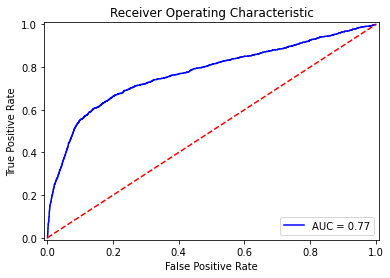

In [604]:
plot_roc_curve(y_test, probs_log)

### Naive Bayes

In [605]:
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gaussian,f1_gaussian = algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_gaussian,y_test) )

Accuracy: 83.17
Accuracy CV 10-Fold: 83.44
Running Time: 0:00:00.459316
Kappa Score is  0.2964779406605186


In [606]:
print (metrics.classification_report(y_train, train_pred_gaussian))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     24529
           1       0.33      0.48      0.39      3066

    accuracy                           0.83     27595
   macro avg       0.63      0.68      0.65     27595
weighted avg       0.86      0.83      0.85     27595



In [607]:
print (metrics.classification_report(y_test, test_pred_gaussian))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     12019
           1       0.34      0.47      0.39      1574

    accuracy                           0.83     13593
   macro avg       0.63      0.67      0.65     13593
weighted avg       0.86      0.83      0.84     13593



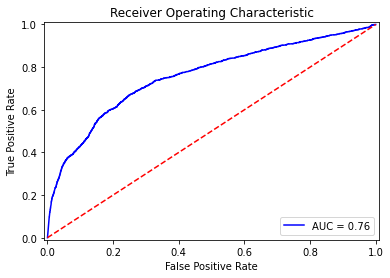

In [608]:
plot_roc_curve(y_test, probs_gaussian)

### Decision Tree Classifier

In [609]:
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt,f1_dt = algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_dt,y_test) )

Accuracy: 84.8
Accuracy CV 10-Fold: 85.12
Running Time: 0:00:01.124078
Kappa Score is  0.22480692865669583


In [610]:
print (metrics.classification_report(y_train, train_pred_dt))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     24529
           1       0.33      0.32      0.32      3066

    accuracy                           0.85     27595
   macro avg       0.62      0.62      0.62     27595
weighted avg       0.85      0.85      0.85     27595



In [611]:
print (metrics.classification_report(y_test, test_pred_dt))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     12019
           1       0.33      0.29      0.31      1574

    accuracy                           0.85     13593
   macro avg       0.62      0.61      0.61     13593
weighted avg       0.84      0.85      0.84     13593



### Linear SVC

In [612]:

start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, probs_linear_svc, f1_linear_svc = algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_svc,y_test) )

Accuracy: 89.46
Accuracy CV 10-Fold: 90.04
Running Time: 0:00:32.669258
Kappa Score is  0.2650349562485165


In [613]:
print (metrics.classification_report(y_train, train_pred_svc))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     24529
           1       0.66      0.21      0.32      3066

    accuracy                           0.90     27595
   macro avg       0.79      0.60      0.63     27595
weighted avg       0.88      0.90      0.88     27595



In [614]:
print (metrics.classification_report(y_test, test_pred_svc))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12019
           1       0.64      0.20      0.31      1574

    accuracy                           0.89     13593
   macro avg       0.77      0.59      0.62     13593
weighted avg       0.87      0.89      0.87     13593



### Random Forest Classifier - Random Search for Hyperparameters

In [615]:


# Utility function to report best scores

def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 3.95 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.902 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 11, 'min_samples_split': 8}

Model with rank: 2
Mean validation score: 0.902 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 19, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.901 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 12, 'min_samples_split': 22}

Model with rank: 4
Mean validation score: 0.901 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 18, 'min_samples_split': 7}

Model with rank: 5
Mean validation score: 0.901 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_

In [616]:
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=15,
                             min_samples_split=25, 
                             criterion='entropy', 
                             max_features=5)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf, f1_rf = algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_rf,y_test) )

Accuracy: 89.54
Accuracy CV 10-Fold: 90.09
Running Time: 0:00:01.284991
Kappa Score is  0.2969972062823041


In [617]:
print (metrics.classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     24529
           1       0.64      0.25      0.35      3066

    accuracy                           0.90     27595
   macro avg       0.78      0.61      0.65     27595
weighted avg       0.88      0.90      0.88     27595



In [618]:
print (metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12019
           1       0.63      0.23      0.34      1574

    accuracy                           0.90     13593
   macro avg       0.77      0.61      0.64     13593
weighted avg       0.88      0.90      0.87     13593



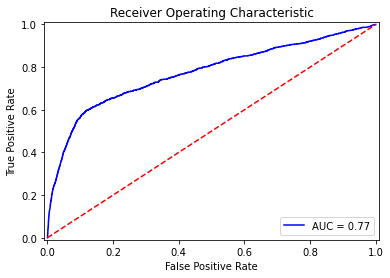

In [619]:
plot_roc_curve(y_test, probs_rf)

# Gradient Boosting Trees

In [620]:

start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt, f1_gbt = algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_gbt,y_test) )

Accuracy: 89.65
Accuracy CV 10-Fold: 90.38
Running Time: 0:00:10.384100
Kappa Score is  0.3041485049727637


In [621]:
print (metrics.classification_report(y_train, train_pred_gbt))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     24529
           1       0.67      0.26      0.38      3066

    accuracy                           0.90     27595
   macro avg       0.79      0.62      0.66     27595
weighted avg       0.89      0.90      0.88     27595



In [622]:
print (metrics.classification_report(y_test, test_pred_gbt))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12019
           1       0.64      0.24      0.35      1574

    accuracy                           0.90     13593
   macro avg       0.78      0.61      0.65     13593
weighted avg       0.88      0.90      0.87     13593



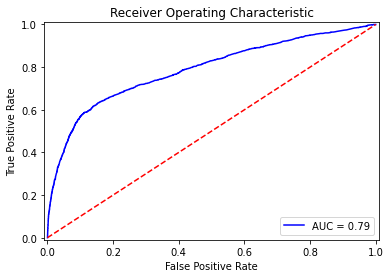

In [623]:
plot_roc_curve(y_test, probs_gbt)

### AdaBoost 

In [624]:
start_time = time.time()
dt_model = DecisionTreeClassifier(criterion = 'entropy',random_state=100)
train_pred_abcl, test_pred_abcl, acc_abcl, acc_cv_abcl, probs_abcl, f1_abcl = algo(AdaBoostClassifier(base_estimator=dt_model, n_estimators=100,random_state=100), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
abcl_time = (time.time() - start_time)
print("Accuracy: %s" % acc_abcl)
print("Accuracy CV 10-Fold: %s" % acc_cv_abcl)
print("Running Time: %s" % datetime.timedelta(seconds=abcl_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_abcl,y_test) )

Accuracy: 86.8
Accuracy CV 10-Fold: 87.35
Running Time: 0:00:15.811939
Kappa Score is  0.2522733661640988


In [625]:
print (metrics.classification_report(y_train, train_pred_abcl))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     24529
           1       0.40      0.29      0.34      3066

    accuracy                           0.87     27595
   macro avg       0.66      0.62      0.64     27595
weighted avg       0.86      0.87      0.86     27595



In [626]:
print (metrics.classification_report(y_test, test_pred_abcl))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     12019
           1       0.40      0.27      0.32      1574

    accuracy                           0.87     13593
   macro avg       0.65      0.61      0.62     13593
weighted avg       0.85      0.87      0.86     13593



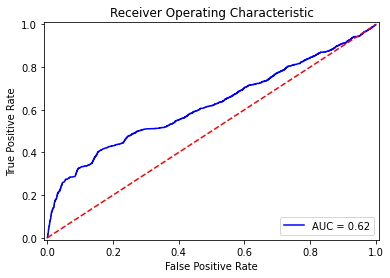

In [627]:
plot_roc_curve(y_test, probs_abcl)

### Multiple model Ensemble - VotingClassifier - GridSearch for Hyperparameters

In [628]:


start_time = time.time()
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft')
params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}


train_pred_gs, test_pred_gs, acc_gs, acc_cv_gs, probs_gs,f1_gs = algo(GridSearchCV(scoring = f1,estimator=eclf, param_grid=params, cv=5,), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gs_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gs)
print("Accuracy CV 10-Fold: %s" % acc_cv_gs)
print("Running Time: %s" % datetime.timedelta(seconds=gs_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_gs,y_test) )

Accuracy: 67.54
Accuracy CV 10-Fold: 88.85
Running Time: 0:03:25.443823
Kappa Score is  0.35240969443364056


In [629]:
print (metrics.classification_report(y_train, train_pred_gs))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     24529
           1       0.50      0.38      0.43      3066

    accuracy                           0.89     27595
   macro avg       0.71      0.67      0.69     27595
weighted avg       0.88      0.89      0.88     27595



In [630]:
print (metrics.classification_report(y_test, test_pred_gs))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     12019
           1       0.49      0.36      0.42      1574

    accuracy                           0.88     13593
   macro avg       0.70      0.66      0.68     13593
weighted avg       0.87      0.88      0.87     13593



### XGBoost

In [631]:
start_time = time.time()

train_pred_xgb1, test_pred_xgb1, acc_xgb1, acc_cv_xgb1, probs_xgb1, f1_xgb1 = algo(xgb.XGBClassifier(max_depth=5, n_estimators=100 ,class_weight='balanced', n_jobs=-1,), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
xgb_time1 = (time.time() - start_time)
print("Accuracy: %s" % acc_xgb1)
print("Accuracy CV 10-Fold: %s" % acc_cv_xgb1)
print("Running Time: %s" % datetime.timedelta(seconds=xgb_time1))
print("Kappa Score is ",cohen_kappa_score(test_pred_xgb1,y_test) )

[14:25:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 89.41
Accuracy CV 10-Fold: 89.91
Running Time: 0:00:06.622858
Kappa Score is  0.3176488371048839


In [632]:
print (metrics.classification_report(y_train, train_pred_xgb1))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     24529
           1       0.60      0.28      0.38      3066

    accuracy                           0.90     27595
   macro avg       0.76      0.63      0.66     27595
weighted avg       0.88      0.90      0.88     27595



In [633]:
print (metrics.classification_report(y_test, test_pred_xgb1))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12019
           1       0.60      0.26      0.37      1574

    accuracy                           0.89     13593
   macro avg       0.75      0.62      0.65     13593
weighted avg       0.87      0.89      0.88     13593



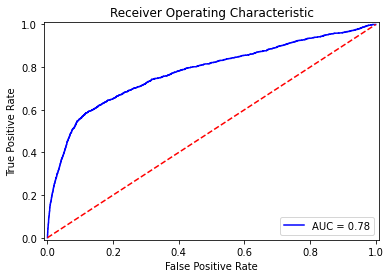

In [634]:
plot_roc_curve(y_test, probs_xgb1)

## We are getting the best results with Multiple model Ensemble - VotingClassifier.We can do SMOTE andcheck for perfromance boost

# SMOTE

In [635]:
from numpy import ravel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
sm = SMOTE(random_state=2)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train.values.ravel())

print("X Train after SMOTE:", X_train_smote.shape)
print("X Train before SMOTE:", X_train.shape)
print("Y Train after SMOTE:", y_train_smote.shape)
print("Y Train before SMOTE:", y_train.shape)

X Train after SMOTE: (49058, 16)
X Train before SMOTE: (27595, 16)
Y Train after SMOTE: (49058,)
Y Train before SMOTE: (27595,)


## Voting Classifier after SMOTE

In [636]:
start_time = time.time()
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft')
params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}


train_pred_gs_smote, test_pred_gs_smote, acc_gs_smote, acc_cv_gs_smote, probs_gs_smote,f1_gs_smote = algo(GridSearchCV(estimator=eclf, param_grid=params, cv=5), 
                                                                 X_train_smote, 
                                                                 y_train_smote, 
                                                                 X_test, 
                                                                 10)
gs_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gs)
print("Accuracy CV 10-Fold: %s" % acc_cv_gs)
print("Running Time: %s" % datetime.timedelta(seconds=gs_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_gs_smote,y_test) )

Accuracy: 67.54
Accuracy CV 10-Fold: 88.85
Running Time: 0:07:19.521811
Kappa Score is  0.37570448491548314


In [637]:
print (metrics.classification_report(y_train_smote, train_pred_gs_smote))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81     24529
           1       0.86      0.71      0.78     24529

    accuracy                           0.80     49058
   macro avg       0.81      0.80      0.80     49058
weighted avg       0.81      0.80      0.80     49058



In [638]:
print (metrics.classification_report(y_test, test_pred_gs_smote))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     12019
           1       0.39      0.56      0.46      1574

    accuracy                           0.85     13593
   macro avg       0.67      0.72      0.69     13593
weighted avg       0.88      0.85      0.86     13593



# Downsampling the Train 

In [639]:
X_d = pd.concat([X_train,y_train],axis=1)

In [640]:
major_class = X_d[X_d["y"]==0].index
minor_class = X_d[X_d["y"]==1].index

In [641]:
print(len(major_class))
print(len(minor_class))

24529
3066


In [642]:
delete = np.random.choice(major_class, size=15000, replace=False)


In [643]:
# splitting again
X_train_d = X_d.drop("y",axis=1)
y_train_d = X_d["y"]

In [644]:
X_train_d = X_train.drop(labels = delete,axis=0)
y_train_d = y_train.drop(labels = delete,axis=0)

## Algorithms

### Logistic- Downsampled

In [645]:
start_time = time.time()
train_pred_log_d, test_pred_log_d, acc_log_d, acc_cv_log_d, probs_log_d,f1_log_d = algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train_d, 
                                                                 y_train_d, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log_d)
print("Accuracy CV 10-Fold: %s" % acc_cv_log_d)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_log_d,y_test) )

Accuracy: 88.27
Accuracy CV 10-Fold: 82.03
Running Time: 0:00:01.057568
Kappa Score is  0.36354825443832406


In [646]:
print (metrics.classification_report(y_train_d, train_pred_log_d))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      9529
           1       0.74      0.41      0.52      3066

    accuracy                           0.82     12595
   macro avg       0.79      0.68      0.71     12595
weighted avg       0.81      0.82      0.80     12595



In [647]:
print (metrics.classification_report(y_test, test_pred_log_d))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     12019
           1       0.49      0.38      0.43      1574

    accuracy                           0.88     13593
   macro avg       0.71      0.66      0.68     13593
weighted avg       0.87      0.88      0.88     13593



### XGB- Downsampled

In [648]:
start_time = time.time()

train_pred_xgb1_d, test_pred_xgb1_d, acc_xgb1_d, acc_cv_xgb1_d, probs_xgb1_d,f1_xgb1_d = algo(xgb.XGBClassifier(max_depth=5, n_estimators=100 , n_jobs=-1), 
                                                                 X_train_d, 
                                                                 y_train_d, 
                                                                 X_test, 
                                                                 10)
xgb_time1 = (time.time() - start_time)
print("Accuracy: %s" % acc_xgb1_d)
print("Accuracy CV 10-Fold: %s" % acc_cv_xgb1_d)
print("Running Time: %s" % datetime.timedelta(seconds=xgb_time1))
print("Kappa Score is ",cohen_kappa_score(test_pred_xgb1_d,y_test) )

Accuracy: 87.77
Accuracy CV 10-Fold: 82.79
Running Time: 0:00:02.967355
Kappa Score is  0.399062144778243


In [649]:
print (metrics.classification_report(y_train_d, train_pred_xgb1_d))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      9529
           1       0.71      0.49      0.58      3066

    accuracy                           0.83     12595
   macro avg       0.78      0.71      0.74     12595
weighted avg       0.82      0.83      0.82     12595



In [650]:
print (metrics.classification_report(y_test, test_pred_xgb1_d))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12019
           1       0.47      0.47      0.47      1574

    accuracy                           0.88     13593
   macro avg       0.70      0.70      0.70     13593
weighted avg       0.88      0.88      0.88     13593



### Naive Bayes- Downsampled

In [651]:
start_time = time.time()
train_pred_gaussian_d, test_pred_gaussian_d, acc_gaussian_d, acc_cv_gaussian_d, probs_gaussian_d,f1_gaussian_d = algo(GaussianNB(), 
                                                                                     X_train_d, 
                                                                                     y_train_d, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian_d)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian_d)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_gaussian_d,y_test) )

Accuracy: 82.39
Accuracy CV 10-Fold: 77.86
Running Time: 0:00:00.200499
Kappa Score is  0.3036979689205629


In [652]:
print (metrics.classification_report(y_train_d, train_pred_gaussian_d))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      9529
           1       0.55      0.52      0.53      3066

    accuracy                           0.78     12595
   macro avg       0.70      0.69      0.69     12595
weighted avg       0.77      0.78      0.78     12595



In [653]:
print (metrics.classification_report(y_test, test_pred_gaussian_d))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90     12019
           1       0.33      0.51      0.40      1574

    accuracy                           0.82     13593
   macro avg       0.63      0.69      0.65     13593
weighted avg       0.86      0.82      0.84     13593



### Multiple ensemble -Voting- Downsampled

In [654]:
start_time = time.time()
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft')
params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}


train_pred_gs_d, test_pred_gs_d, acc_gs_d, acc_cv_gs_d, probs_gs_d,f1_gs_d = algo(GridSearchCV(estimator=eclf, param_grid=params, cv=5), 
                                                                 X_train_d, 
                                                                 y_train_d, 
                                                                 X_test, 
                                                                 10)
gs_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gs_d)
print("Accuracy CV 10-Fold: %s" % acc_cv_gs_d)
print("Running Time: %s" % datetime.timedelta(seconds=gs_time))
print("Kappa Score is ",cohen_kappa_score(test_pred_gs_d,y_test) )

Accuracy: 86.79
Accuracy CV 10-Fold: 82.11
Running Time: 0:01:41.760151
Kappa Score is  0.3833625844051963


In [655]:
print (metrics.classification_report(y_train_d, train_pred_gs_d))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      9529
           1       0.67      0.52      0.58      3066

    accuracy                           0.82     12595
   macro avg       0.76      0.72      0.74     12595
weighted avg       0.81      0.82      0.81     12595



In [656]:
print (metrics.classification_report(y_test, test_pred_gs_d))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     12019
           1       0.44      0.48      0.46      1574

    accuracy                           0.87     13593
   macro avg       0.68      0.70      0.69     13593
weighted avg       0.87      0.87      0.87     13593



# Score Card of Accuracy

In [657]:
models_accuracy = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'AdaBoostClassifier',             
              'Multiple model Ensemble',
              'XGBoost',
              'Multiple model Ensemble After SMOTE',
             'Logistic Regression-Downsampled',              
              'Naive Bayes-Downsampled',
              'XGBoost-Downsampled',
             'Multiple model Ensemble Downsampled'],
    'Score': [
         
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian,          
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,        
        acc_cv_abcl,        
        acc_cv_gs,
        acc_cv_xgb1,
        acc_cv_gs_smote,
        acc_cv_log_d,
        acc_cv_gaussian_d,
        acc_cv_xgb1_d,
        acc_cv_gs_d
    ]})
models_accuracy.sort_values(by='Score', ascending=False)

,Model,Score
5,Gradient Boosting Trees,90.38
1,Random Forest,90.09
3,Linear SVC,90.04
0,Logistic Regression,89.97
8,XGBoost,89.91
7,Multiple model Ensemble,88.85
6,AdaBoostClassifier,87.35
4,Decision Tree,85.12
2,Naive Bayes,83.44
12,XGBoost-Downsampled,82.79


# Score Card of F1 Score

In [658]:
models_F1 = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'AdaBoostClassifier',              
              'Multiple model Ensemble ',
              'XGBoost',
             'Multiple model Ensemble After SMOTE',
            'Logistic Regression-Downsampled',              
              'Naive Bayes-Downsampled',
              'XGBoost-Downsampled',
             'Multiple model Ensemble Downsampled'
             ],
    'F1_Score': [
         
        f1_log,     
        f1_rf, 
        f1_gaussian,          
        f1_linear_svc, 
        f1_dt,
        f1_gbt,        
        f1_abcl,        
        f1_gs,
        f1_xgb1,
        f1_gs_smote,
        f1_log_d,
        f1_gaussian_d,
        f1_xgb1_d,
        f1_gs_d
    
    ]})
models_F1.sort_values(by='F1_Score', ascending=False)

,Model,F1_Score
12,XGBoost-Downsampled,69.95
13,Multiple model Ensemble Downsampled,69.16
9,Multiple model Ensemble After SMOTE,68.63
10,Logistic Regression-Downsampled,68.12
7,Multiple model Ensemble,67.54
8,XGBoost,65.42
11,Naive Bayes-Downsampled,64.91
2,Naive Bayes,64.68
5,Gradient Boosting Trees,64.57
1,Random Forest,64.21


# Metrics Comparison

In [659]:
metrics_comparison = pd.read_excel(r"C:\Users\Admin\Downloads\gl\CAPSTONE\BANK MARKETING\new dataset with 20 input\bank-additional\Metrics DataFrame.xlsx")
metrics_comparison

,Model Name,Accuracy Score,Kappa Score,Precision Score,Recall Score,F1 score
0,Logistic Regression,89.97,0.281,0.77,0.60,0.63
1,Naïve Bayes,83.44,0.296,0.63,0.67,0.65
2,Decision Tree Classifier,85.16,0.223,0.62,0.61,0.61
3,Linear SVC,90.04,0.265,0.77,0.59,0.62
4,Random Forest,90.19,0.295,0.77,0.61,0.64
5,Gradient Boosting Trees,90.38,0.304,0.78,0.61,0.65
6,Adaboost,87.35,0.252,0.65,0.61,0.62
7,Multiple Ensemble-Voting,88.35,0.353,0.70,0.66,0.68
8,XGBoost,89.91,0.317,0.75,0.62,0.65
9,Multiple Ensemble-Voting-SMOTE,88.85,0.375,0.67,0.72,0.69


### Conclusions
- It was a great learning experience working on a financial dataset.
- Our dataset consist of categorical and numerical features.
- Duration was an important parameter but it cannot be used for prediction as it is not available before making the call
- When visualized age in groups, it is found that clients with age less than 30 and greater than 60 are less contacted through   the campaign but have a higher success rate.
- The biggest issue with the dataset was a imbalanced one with proportion of 89:12
- The number of datapoints is also aroud 42000 which made the balancing difficult
- Different machine learning models are trained and tested on the dataset. 
- Different models are summarized in table above.
- If accuracy was taken as the metric, Gradient boosting trees and Random Forest are showing Best performances. 
- If F1 score was taken as the metric, XGBoost with Downsamples train and Mulitple Ensemble model after SMOTE are showing Best performances
- The Methods like SMOTE and Downsampling influenced on improving the F1 score.
- Based on the Subject Matter Expert we can decide on which metric to be used Precision or Recall and try to improce that single metric to improve the model performance in further studies
- The Tradeoff between Precision and Recall is inevitable in these kind of imbalanced problems
